In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize, ndimage
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

In [468]:
def smoothing2(X, smooth=5, spike_width=3):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 1))
    mean_grad = np.mean(grad_abs, 1) + np.std(grad_abs, 1)
    noise_to_signal_quality = ndimage.gaussian_filter((grad_abs_sm.T < mean_grad).T.astype(float), (0, spike_width))
    return noise_to_signal_quality * ndimage.gaussian_filter(X, (0,smooth)) + (1-noise_to_signal_quality) * X


def smoothing(X, smooth=5, transition=10, spike_width=7):
    """
    Only remove noise from low noise to signal area's to maintain the intensity of the spikes.
    Noise is removed with a gaussian filter in spectral dimension.
    """
    grad = ndimage.gaussian_filter(X, (0, 1), order=1)
    grad_abs = np.abs(grad)
    grad_abs_sm = ndimage.gaussian_filter(grad_abs, (0, 5))
    mean_grad = np.mean(grad_abs, 1) + 1 / np.std(grad_abs, 1) * 3
    
    spikes = ((grad_abs_sm.T > mean_grad ).astype(float)).T 
    spikes = np.round(ndimage.gaussian_filter(spikes, (0, spike_width)))
    spikes = ndimage.uniform_filter(spikes, (0, transition))
    
    i = 5458
    i = 5703
#     i = 4563

    plt.figure(figsize = (10,6), dpi=500)
    plt.plot(wavelength, X[i], label='raw data', alpha=0.5)
    plt.plot(wavelength, grad_abs_sm[i]*5, label='absoluut gradient', alpha=0.7)
    plt.plot(wavelength, spikes[i]*100, label='p(Raman spikes)')
#     plt.plot([0,3000], [mean_grad[i]*15, mean_grad[i]*15], '--r')
    plt.xlabel("wavenumber ($cm^{-1}$)")
    plt.ylabel("Intensity(-) / probablity(%)")
    axes = plt.gca()
    axes.set_xlim([80,1600])
    axes.set_ylim([0,450])
    plt.legend()
    plt.show()
    
    return (1 - spikes) * ndimage.gaussian_filter(X, (0,smooth)) + spikes * X



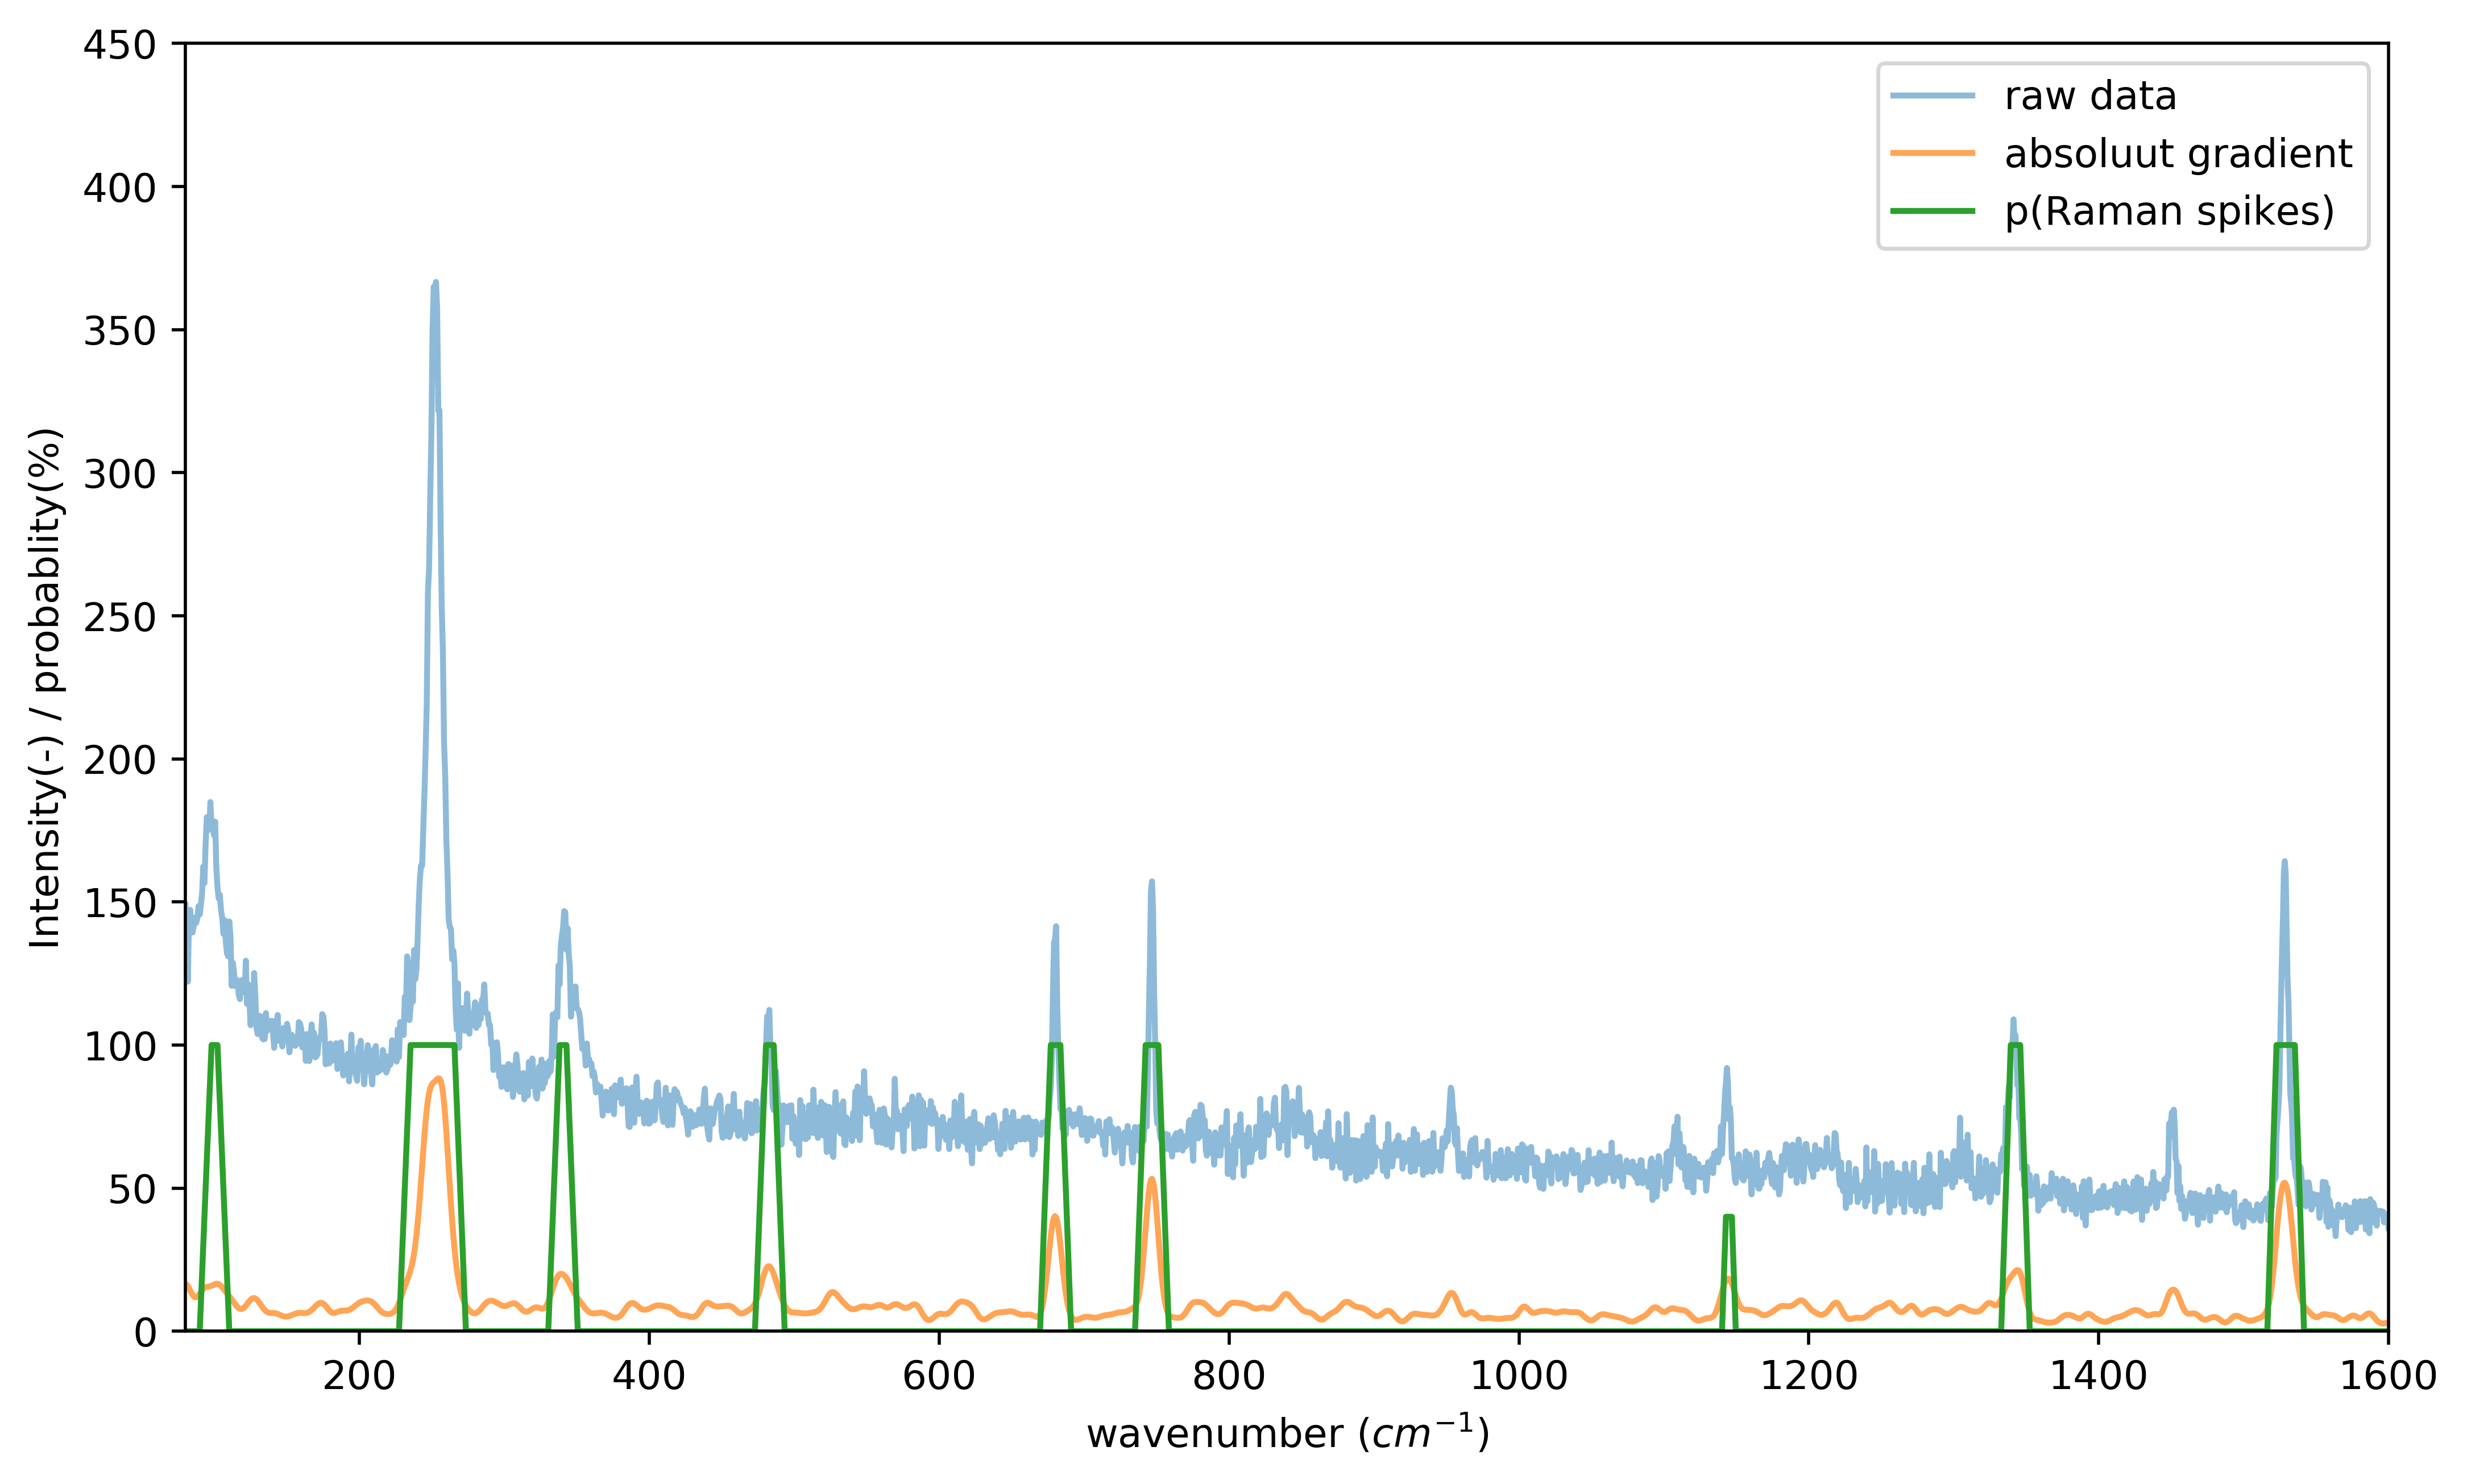

In [469]:
N_WAVE = 2126 * 2

# X = np.load("../data/Raman/Alina_art_1_1.npy", 'r')
Y = np.load("../data/Raman/Alina_Art_4_2.npy", 'r')

wavelength = np.load("../data/Raman/wavelength.npy", 'r')

# shape_X = X.shape 
shape_Y = Y.shape

# X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))

# ram_X, afl_X = split_Raman_af(X)
# ram_smooth_X = smoothing(ram_X, s)

Ram = smoothing(Y, 5, 10, 7)


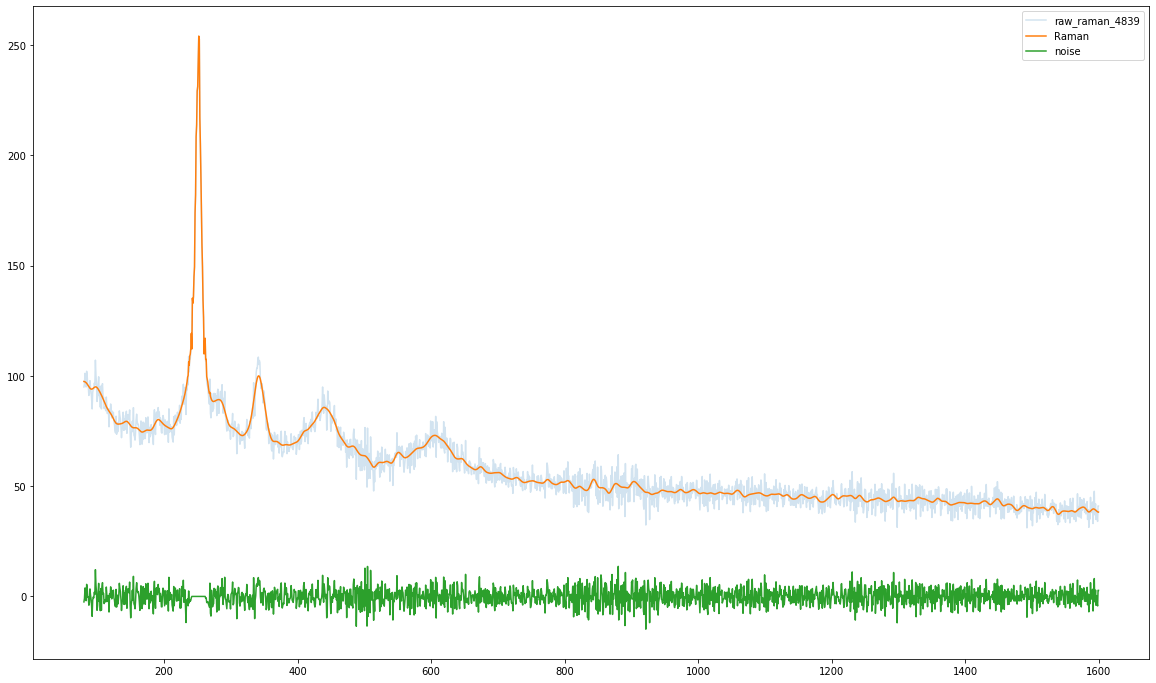

In [456]:

i = random.randint(0, 6026)
# i = 5703
# i = 4563
plt.figure(figsize = (20,12))
plt.plot(wavelength, Y[i], label='raw_raman_'+str(i), alpha=0.2)
plt.plot(wavelength, Ram[i], label='Raman', alpha=1)
plt.plot(wavelength, Y[i]-Ram[i], label='noise')
plt.legend()
plt.show()

In [424]:
i

5458